<a href="https://colab.research.google.com/github/sgu20191619/DACON/blob/main/LGAImers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret

In [ ]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sklearn
sklearn.__version__

'0.23.2'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/LGAimers/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/LGAimers/test.csv")

In [ ]:
train_df.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_df.describe()

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,598.000000,598.000000,349.000000,349.000000,349.0,349.0,349.000000,349.0,349.000000,349.000000,...,100.000000,100.00000,100.000000,100.000000,100.00000,99.0,0.0,0.0,0.0,0.0
mean,1.025084,0.530896,2.409742,95.123209,0.0,45.0,10.392550,0.0,48.802292,10.048711,...,50.807300,53.60770,49.606200,51.659800,66.64970,1.0,NaN,NaN,NaN,NaN
std,0.565069,0.007401,5.895256,4.107640,0.0,0.0,0.489019,0.0,4.373824,0.215571,...,7.011828,8.13899,7.158917,8.913065,4.52781,0.0,NaN,NaN,NaN,NaN
min,0.000000,0.500856,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,32.120000,31.70000,32.560000,30.490000,61.67000,1.0,NaN,NaN,NaN,NaN
25%,1.000000,0.527535,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,49.485000,52.20000,42.160000,49.915000,63.64500,1.0,NaN,NaN,NaN,NaN
50%,1.000000,0.530436,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,53.425000,55.92500,51.460000,56.175000,65.14000,1.0,NaN,NaN,NaN,NaN
75%,1.000000,0.533433,2.000000,98.000000,0.0,45.0,11.000000,0.0,51.000000,10.000000,...,55.287500,58.97500,55.030000,57.175000,67.11500,1.0,NaN,NaN,NaN,NaN
max,2.000000,0.578841,103.000000,102.000000,0.0,45.0,11.000000,0.0,62.000000,11.000000,...,60.240000,68.66000,60.410000,59.930000,79.75000,1.0,NaN,NaN,NaN,NaN


In [ ]:
def print_statistics(df, col):

  max = df[col].max()
  min = df[col].min()
  mean = df[col].mean()
  median = df[col].median()

  print(f'{col}의 최대값 : {max}')
  print(f'{col}의 최소값 : {min}')
  print(f'{col}의 평균값 : {mean}')
  print(f'{col}의 중앙값 : {median}')

In [ ]:
def value_hist(df, col, target='Y_Quality'):

  for value in df[col].unique():

    cond = (df[col]==value)
    cond_df = df.loc[cond]

    print(f'{value} 데이터 갯수 : {cond_df.shape[0]}')
    print_statistics(cond_df, target)

    fig, ax = plt.subplots(ncols=2, figsize=(13, 6))

    sns.histplot(data=cond_df, x='Y_Quality', ax=ax[0])
    ax[0].set_title(f'{col} {value}')
    ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)

    sns.boxplot(data=cond_df, x='Y_Quality', ax=ax[1])
    ax[1].set_title(f'{col} {value} Box Plot')
    
    plt.show()

In [ ]:
def value_hist2(df, col, target='Y_Class'):

  for value in df[col].unique():

    cond = (df[col]==value)
    cond_df = df.loc[cond]

    print(f'{value} 데이터 갯수 : {cond_df.shape[0]}')
    print_statistics(cond_df, target)

    fig, ax = plt.subplots(ncols=2, figsize=(13, 6))

    sns.histplot(data=cond_df, x='Y_Class', ax=ax[0])
    ax[0].set_title(f'{col} {value}')
    ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)

    sns.boxplot(data=cond_df, x='Y_Class', ax=ax[1])
    ax[1].set_title(f'{col} {value} Box Plot')
    
    plt.show()

1 데이터 갯수 : 407
Y_Quality의 최대값 : 0.534842857
Y_Quality의 최소값 : 0.525085714
Y_Quality의 평균값 : 0.5302534412850123
Y_Quality의 중앙값 : 0.530307937


<ipython-input-14-2faa018d6214>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


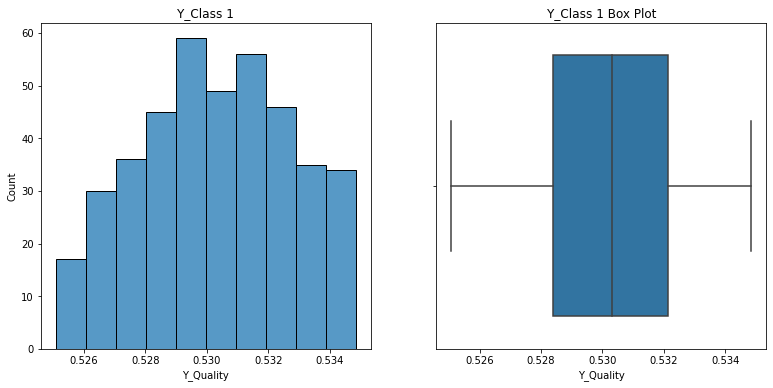

2 데이터 갯수 : 103
Y_Quality의 최대값 : 0.57884127
Y_Quality의 최소값 : 0.534950794
Y_Quality의 평균값 : 0.5420308521844659
Y_Quality의 중앙값 : 0.538507937


<ipython-input-14-2faa018d6214>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


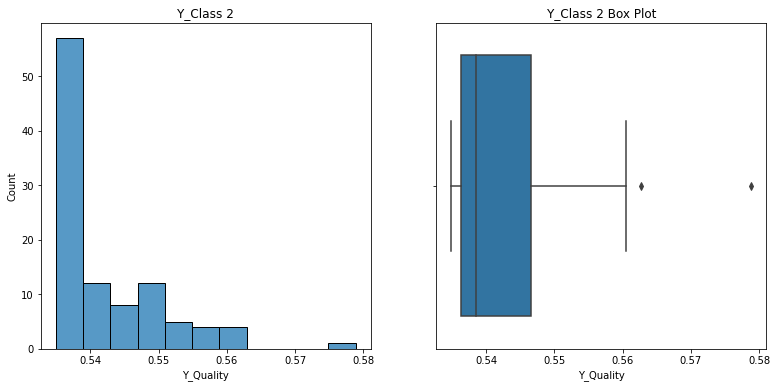

0 데이터 갯수 : 88
Y_Quality의 최대값 : 0.525066667
Y_Quality의 최소값 : 0.500855556
Y_Quality의 평균값 : 0.5208367966249999
Y_Quality의 중앙값 : 0.5220539685000001


<ipython-input-14-2faa018d6214>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


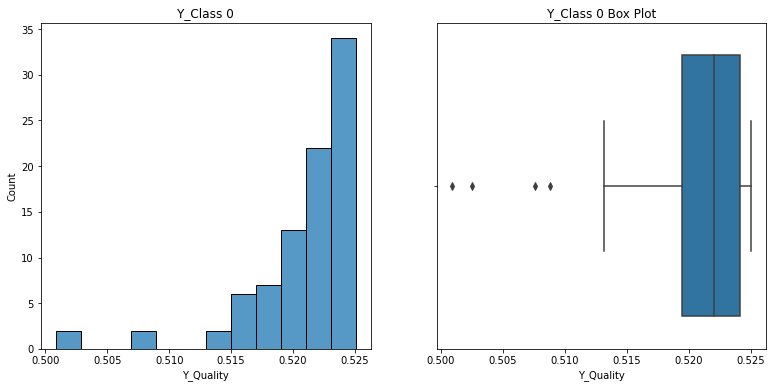

In [ ]:
value_hist(train_df,"Y_Class")

A_31 데이터 갯수 : 249
Y_Class의 최대값 : 2
Y_Class의 최소값 : 0
Y_Class의 평균값 : 1.0441767068273093
Y_Class의 중앙값 : 1.0


<ipython-input-15-3ac6e3c47aca>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


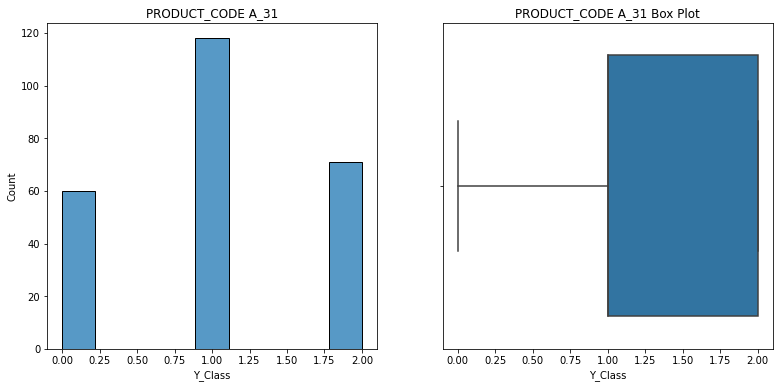

T_31 데이터 갯수 : 343
Y_Class의 최대값 : 2
Y_Class의 최소값 : 0
Y_Class의 평균값 : 1.0058309037900874
Y_Class의 중앙값 : 1.0


<ipython-input-15-3ac6e3c47aca>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


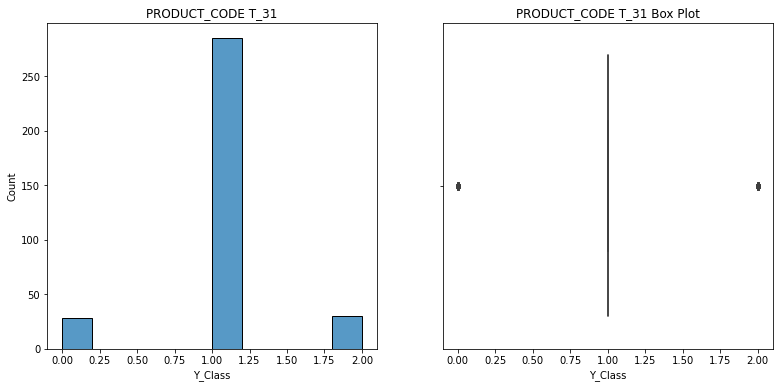

O_31 데이터 갯수 : 6
Y_Class의 최대값 : 2
Y_Class의 최소값 : 1
Y_Class의 평균값 : 1.3333333333333333
Y_Class의 중앙값 : 1.0


<ipython-input-15-3ac6e3c47aca>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


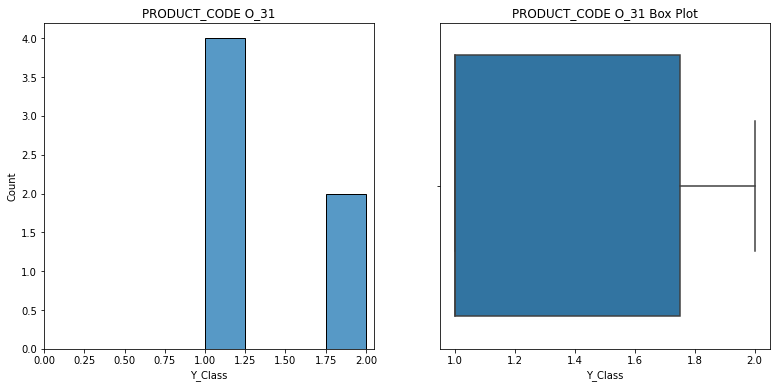

In [ ]:
value_hist2(train_df,"PRODUCT_CODE")

In [ ]:
train_A = train_df.loc[train_df['PRODUCT_CODE'].isin(['A_31'])]
train_T = train_df.loc[train_df['PRODUCT_CODE'].isin(['T_31'])]
train_O = train_df.loc[train_df['PRODUCT_CODE'].isin(['O_31'])]

T050304 데이터 갯수 : 78
Y_Class의 최대값 : 2
Y_Class의 최소값 : 0
Y_Class의 평균값 : 0.7564102564102564
Y_Class의 중앙값 : 1.0


<ipython-input-15-3ac6e3c47aca>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


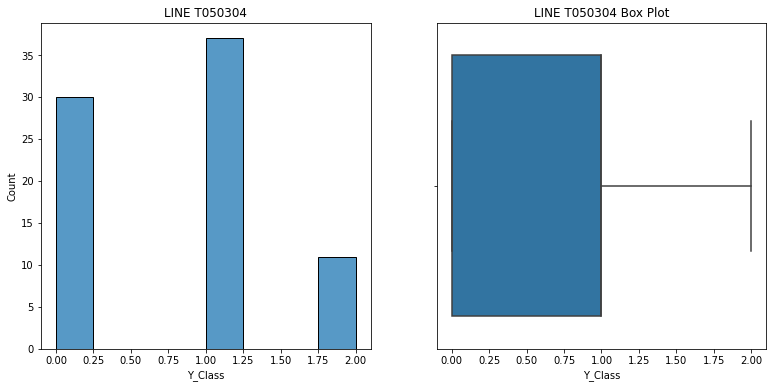

T050307 데이터 갯수 : 42
Y_Class의 최대값 : 2
Y_Class의 최소값 : 0
Y_Class의 평균값 : 1.2619047619047619
Y_Class의 중앙값 : 2.0


<ipython-input-15-3ac6e3c47aca>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


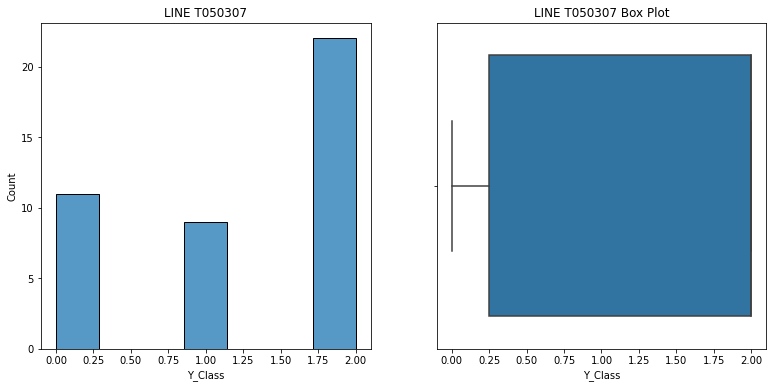

T010306 데이터 갯수 : 70
Y_Class의 최대값 : 2
Y_Class의 최소값 : 0
Y_Class의 평균값 : 1.3
Y_Class의 중앙값 : 1.0


<ipython-input-15-3ac6e3c47aca>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


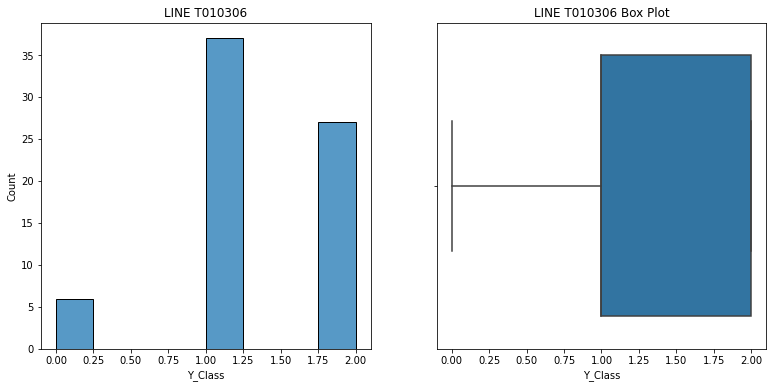

T010305 데이터 갯수 : 59
Y_Class의 최대값 : 2
Y_Class의 최소값 : 0
Y_Class의 평균값 : 0.9661016949152542
Y_Class의 중앙값 : 1.0


<ipython-input-15-3ac6e3c47aca>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


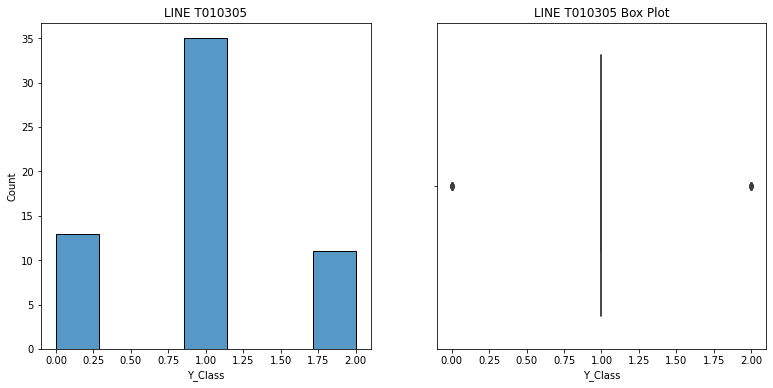

In [ ]:
value_hist2(train_A, "LINE")

T100304 데이터 갯수 : 172
Y_Class의 최대값 : 2
Y_Class의 최소값 : 0
Y_Class의 평균값 : 0.9825581395348837
Y_Class의 중앙값 : 1.0


<ipython-input-15-3ac6e3c47aca>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


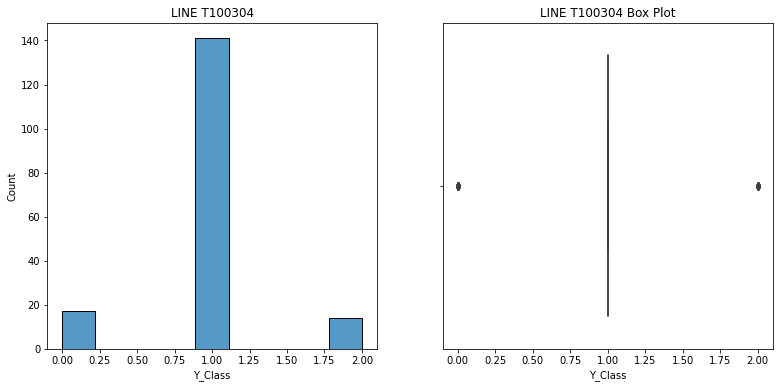

T100306 데이터 갯수 : 171
Y_Class의 최대값 : 2
Y_Class의 최소값 : 0
Y_Class의 평균값 : 1.0292397660818713
Y_Class의 중앙값 : 1.0


<ipython-input-15-3ac6e3c47aca>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


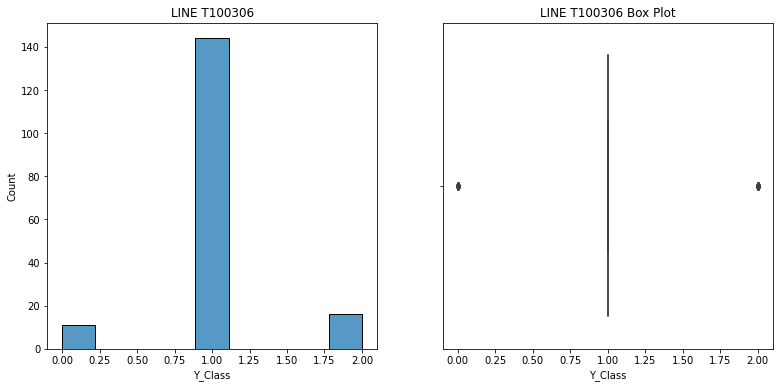

In [ ]:
value_hist2(train_T, "LINE")

T100304 데이터 갯수 : 3
Y_Class의 최대값 : 1
Y_Class의 최소값 : 1
Y_Class의 평균값 : 1.0
Y_Class의 중앙값 : 1.0


<ipython-input-15-3ac6e3c47aca>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


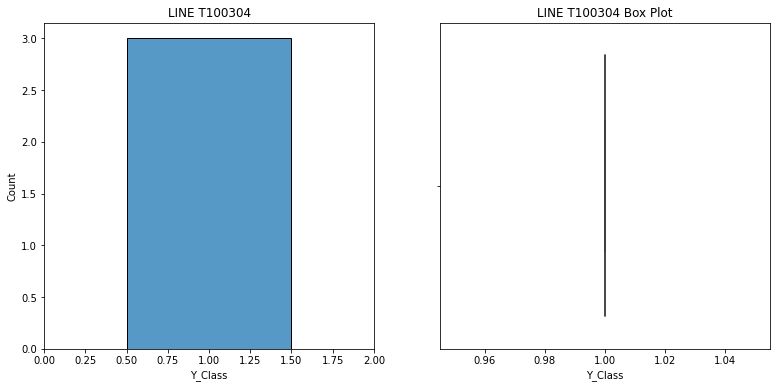

T100306 데이터 갯수 : 3
Y_Class의 최대값 : 2
Y_Class의 최소값 : 1
Y_Class의 평균값 : 1.6666666666666667
Y_Class의 중앙값 : 2.0


<ipython-input-15-3ac6e3c47aca>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)


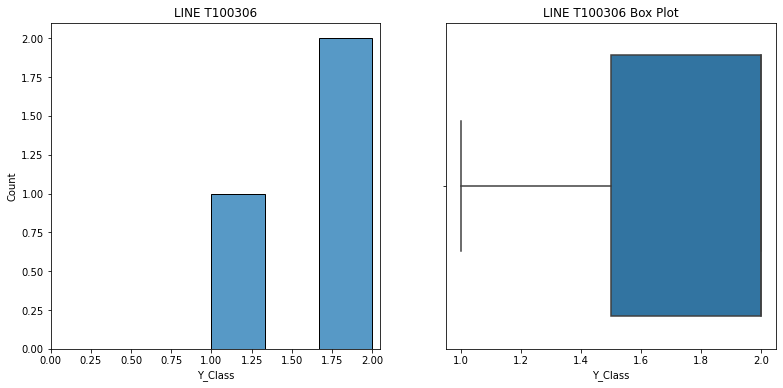

In [ ]:
value_hist2(train_O, "LINE")

In [ ]:
code = train_df["PRODUCT_CODE"].unique()
code.sort()

In [ ]:
train_product = [] 
for i in code :
  train_product.append(train_df.loc[train_df['PRODUCT_CODE'].isin([i])])

In [ ]:
code = test_df["PRODUCT_CODE"].unique()
code.sort()

In [ ]:
test_product = [] 
for i in code :
  test_product.append(test_df.loc[test_df['PRODUCT_CODE'].isin([i])])

In [ ]:
def missing(df) :
  columns = df.columns
  len = df.shape[0]
  for col in columns :
    if (df[col].isnull().sum() == len) :
      df[col] = 0

In [ ]:
for i in range(len(train_product)) :
  missing(train_product[i])

for i in range(len(test_product)) :
  missing(test_product[i])

In [ ]:
line = train_df['LINE'].unique()
line.sort()
train_line = []

for df in train_product : 
  for i in line : 
    train_line.append(df.loc[df['LINE'].isin([i])])

for df in train_line :
  missing(df) 

for i in range(len(train_line)) :
  train_line[i] = train_line[i].fillna(train_line[i].mean())

In [ ]:
final_train = pd.DataFrame()
for df in train_line :
  final_train = pd.concat([final_train, df])

final_train = final_train.sort_values("PRODUCT_ID")
final_train.head()

In [ ]:
line = test_df['LINE'].unique()
line.sort()
test_line = []

for df in test_product : 
  for i in line : 
    test_line.append(df.loc[df['LINE'].isin([i])])

for df in test_line :
  missing(df) 

for i in range(len(test_line)) :
  test_line[i] = test_line[i].fillna(train_line[i].mean())

In [ ]:
final_test = pd.DataFrame()
for df in test_line :
  final_test = pd.concat([final_test, df])

final_test = final_test.sort_values('PRODUCT_ID')

In [ ]:
target_Class = final_train['Y_Class']
target_Quality = final_train['Y_Quality']
final_train = final_train.drop(["PRODUCT_ID", "Y_Class", "TIMESTAMP"], axis = 1)

In [ ]:
final_train.head()

In [ ]:
final_test = final_test.drop(["PRODUCT_ID", "TIMESTAMP"], axis = 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import random
import os

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [ ]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(final_train[i])
    final_train[i] = le.transform(final_train[i])
    
    for label in np.unique(final_test[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    final_test[i] = le.transform(final_test[i]) 
print('Done.')

Done.


In [ ]:
final_train.head()

,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,0.533433,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.34,40.89,32.56,34.09,77.77,1.0,0,0,0,0
1,0.541819,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,1.0,0,0,0,0
2,0.531267,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.19,36.65,42.47,36.53,78.35,1.0,0,0,0,0
3,0.537325,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,1.0,0,0,0,0
4,0.531590,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.70,41.89,46.93,33.09,76.97,1.0,0,0,0,0


In [ ]:
final_test.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,5,2,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,2,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,2,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [ ]:
from pycaret.regression import *

In [ ]:
reg1 = setup(data = final_train, target = 'Y_Quality', silent = True)

In [ ]:
best_model = compare_models()
final_model = finalize_model(best_model)

predictions = predict_model(final_model, data = final_test)

In [ ]:
from pycaret.classification import *

In [ ]:
train_new = pd.concat([final_train, target_Class], axis = 1)
clf1 = setup(data = train_new, target = 'Y_Class', silent = True)

In [ ]:
best_model2 = compare_models()
final_model2 = finalize_model(best_model2)

In [ ]:
predictions.rename(columns={predictions.columns[-1]: 'Y_Quality'}, inplace=True)
predictions.head()

In [ ]:
final_preds = predict_model(final_model2, data = predictions)
final_preds.head()

In [ ]:
pred_Class = final_preds['Label']
pred_Class

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/LGAimers/sample_submission.csv')

In [ ]:
submit['Y_Class'] = pred_Class

In [ ]:
submit.to_csv('./submission.csv', index=False)